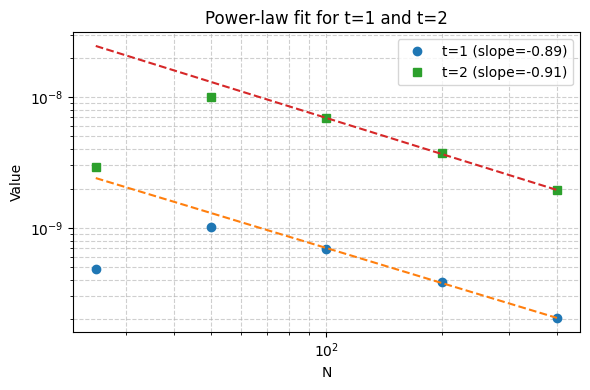

(np.float64(-0.8877666252128461),
 np.float64(-7.378158430395111),
 np.float64(-0.9142236652585798),
 np.float64(-6.331212303009843))

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Data
N = np.array([25, 50, 100, 200, 400])
t1 = np.array([4.84e-10, 1.02e-9, 6.95e-10, 3.87e-10, 2.03e-10])
t2 = np.array([2.91e-9, 1.00e-8, 6.89e-9, 3.71e-9, 1.94e-9])

# Fit log-log lines
logN = np.log10(N[-3::])
log_t1 = np.log10(t1[-3::])
log_t2 = np.log10(t2[-3::])

slope1, intercept1 = np.polyfit(logN, log_t1, 1)
slope2, intercept2 = np.polyfit(logN, log_t2, 1)

# Create smooth line
N_fit = np.geomspace(N.min(), N.max(), 200)
fit_t1 = 10 ** (intercept1 + slope1 * np.log10(N_fit))
fit_t2 = 10 ** (intercept2 + slope2 * np.log10(N_fit))

# Plot
plt.figure(figsize=(6, 4))
plt.loglog(N, t1, "o", label=f"t=1 (slope={slope1:.2f})")
plt.loglog(N_fit, fit_t1, "--")
plt.loglog(N, t2, "s", label=f"t=2 (slope={slope2:.2f})")
plt.loglog(N_fit, fit_t2, "--")
plt.xlabel("N")
plt.ylabel("Value")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.title("Power-law fit for t=1 and t=2")
plt.tight_layout()
plt.show()

slope1, intercept1, slope2, intercept2


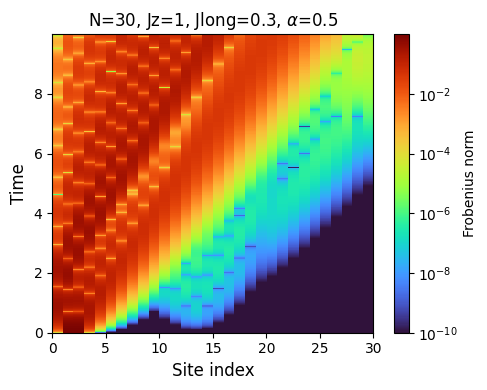

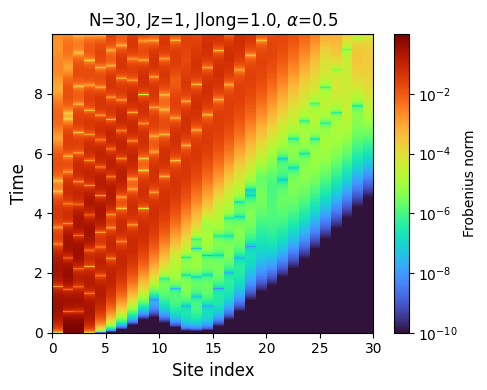

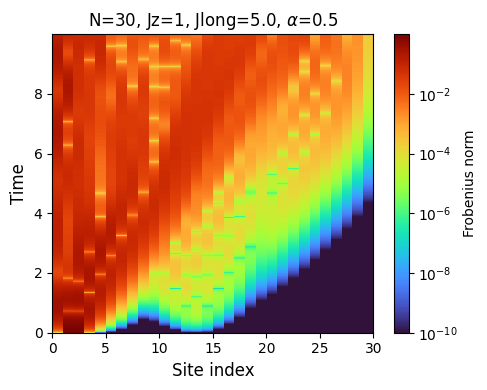

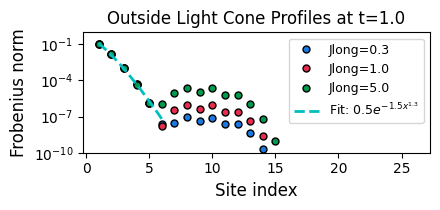

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = [3, 10, 50]
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 1.0

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
all_max = 0
for J in Jlong_values:
    data = load_mathematica_data(os.path.join(base_path, f"N30B0LFIMb2lcfarVaryJlong{J}.txt"))
    all_max = max(all_max, np.nanmax(data))

# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"N30B0LFIMb2lcfarVaryJlong{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 4))
    im = plt.imshow(
    np.clip(raw_data, 1e-10, None),
    aspect="auto",
    origin="lower",
    cmap="turbo",
    norm=mcolors.LogNorm(vmin=1e-10, vmax=all_max),
    interpolation="nearest",   # 👈 No smoothing
    extent=[0, raw_data.shape[1], t_min, t_max],
    rasterized=True            # 👈 Forces raster pixels in SVG/PDF
    )

    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    plt.title(fr"N=30, Jz=1, Jlong={J/10:.1f}, $\alpha$=0.5", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_Jlong{J}.svg", dpi=600)
    plt.show()

# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(4.5, 2.2))
# High-contrast RGB colors (normalized to [0,1])
colors = [
    (0.10, 0.47, 0.88),  # bright blue
    (0.90, 0.17, 0.31),  # red/pink
    (0.00, 0.60, 0.30)   # greenish teal
]


all_x_fit = []
all_y_fit = []

for J, c in zip(Jlong_values, colors):
    file_path = os.path.join(base_path, f"N30B0LFIMb2lcfarVaryJlong{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 4:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect first few points for a single global fit
    n_fit = 6
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])

    plt.semilogy(sites, profile, "o", color=c, markersize=5,
                 markeredgecolor="k", label=f"Jlong={J/10:.1f}")

# -----------------------------
# Fit single model to combined early points
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Compute global fit curve
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)

# Add the single global fit to the same plot
plt.semilogy(x_dense, y_dense, "c--", linewidth=2,
             label=fr"Fit: ${A_fit:.1f}e^{{-{a_fit:.1f}x^{{{p_fit:.1f}}}}}$")

# Final formatting
plt.ylim(1e-10, 1)
plt.xlabel("Site index", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig("plt/Profiles_Overlayed_GlobalFit.svg", dpi=600)
plt.show()


t = 0.10 → slope = 2.000
t = 0.50 → slope = 2.000
t = 2.00 → slope = 1.984


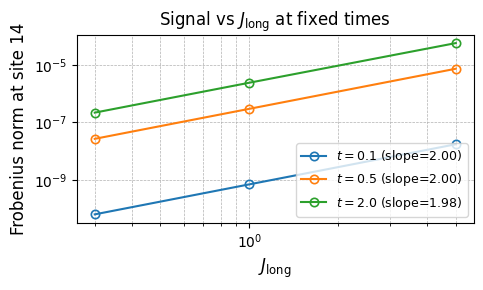

In [ ]:
# -----------------------------
# Plot: Site 14 value vs Jlong at fixed times (log-log)
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

fixed_times = [0.1, 0.5, 2.0]
site_index = 13  # site 14 (0-based)
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(5, 3))

for t_fixed, c in zip(fixed_times, colors):
    values_at_t = []

    for J in Jlong_values:
        file_path = os.path.join(base_path, f"N30B0LFIMb2lcfarVaryJlong{J}.txt")
        raw_data = load_mathematica_data(file_path)
        n_steps = raw_data.shape[0]
        time_axis = np.arange(n_steps) / steps_per_unit

        # Find the closest time index
        idx = np.argmin(np.abs(time_axis - t_fixed))
        val = raw_data[idx, site_index]
        values_at_t.append(val)

    # Convert to arrays for fitting
    J_vals = np.array(Jlong_values) / 10.0
    y_vals = np.array(values_at_t)

    # Fit log(y) = m * log(J) + b  → slope = m
    mask = (y_vals > 1e-14)
    if np.sum(mask) >= 2:
        slope, intercept = np.polyfit(np.log(J_vals[mask]), np.log(y_vals[mask]), 1)
        print(f"t = {t_fixed:>4.2f} → slope = {slope:.3f}")
    else:
        slope = np.nan
        print(f"t = {t_fixed:>4.2f} → insufficient valid points")

    plt.loglog(
        J_vals, y_vals,
        "o-", color=c,
        markerfacecolor='none',
        markeredgewidth=1.2,
        label=fr"$t={t_fixed}$ (slope={slope:.2f})"
    )

plt.xlabel(r"$J_{\mathrm{long}}$", fontsize=12)
plt.ylabel("Frobenius norm at site 14", fontsize=12)
plt.title("Signal vs $J_{\\mathrm{long}}$ at fixed times", fontsize=12)
plt.legend(fontsize=9)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.savefig("plt/Site14_vs_Jlong_fixed_times.svg", dpi=600)
plt.show()


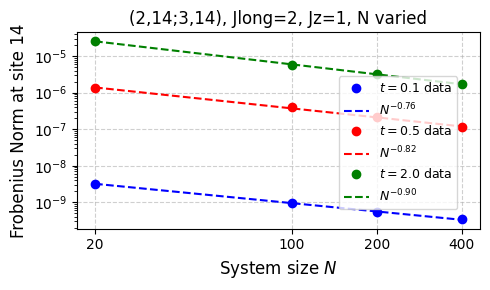

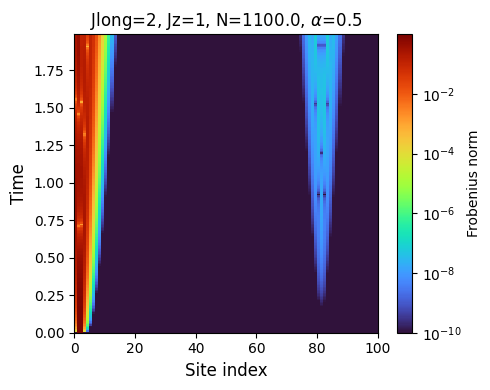

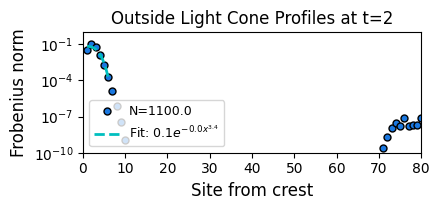

In [54]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = [1100]
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 2

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
all_max = 0
for J in Jlong_values:
    data = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05VaryN{J}.txt"))
    all_max = max(all_max, np.nanmax(data))

# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05VaryN{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 4))
    im = plt.imshow(
    np.clip(raw_data, 1e-10, None),
    aspect="auto",
    origin="lower",
    cmap="turbo",
    norm=mcolors.LogNorm(vmin=1e-10, vmax=all_max),
    interpolation="nearest",   # 👈 No smoothing
    extent=[0, raw_data.shape[1], t_min, t_max],
    rasterized=True            # 👈 Forces raster pixels in SVG/PDF
    )

    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    plt.title(fr"Jlong=2, Jz=1, N={J:.1f}, $\alpha$=0.5", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_N{J}.svg", dpi=600)
    plt.show()

# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(4.5, 2.2))
# High-contrast RGB colors (normalized to [0,1])
colors = [
    (0.10, 0.47, 0.88),  # bright blue
    (0.90, 0.17, 0.31),  # red/pink
    (0.00, 0.60, 0.30)   # greenish teal
]


all_x_fit = []
all_y_fit = []

for J, c in zip(Jlong_values, colors):
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05VaryN{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 4:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect first few points for a single global fit
    n_fit = 6
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])

    plt.semilogy(sites, profile, "o", color=c, markersize=5,
                 markeredgecolor="k", label=f"N={J:.1f}")

# -----------------------------
# Fit single model to combined early points
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Compute global fit curve
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)

# Add the single global fit to the same plot
plt.semilogy(x_dense, y_dense, "c--", linewidth=2,
             label=fr"Fit: ${A_fit:.1f}e^{{-{a_fit:.1f}x^{{{p_fit:.1f}}}}}$")

# Final formatting
plt.ylim(1e-10, 1)
plt.xlim(0, 80)
plt.xlabel("Site from crest", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
plt.legend(fontsize=9, loc="lower left")
plt.tight_layout()
plt.savefig("plt/Profiles_VaryN.svg", dpi=600)
plt.show()


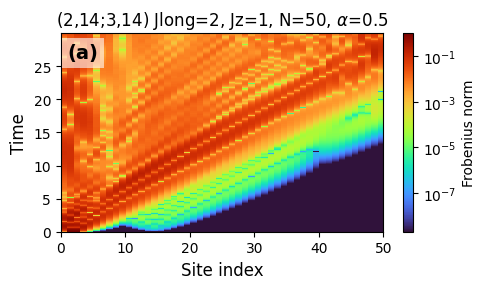

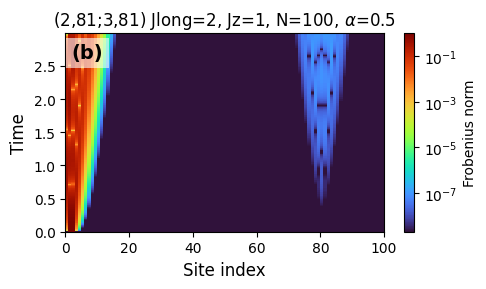

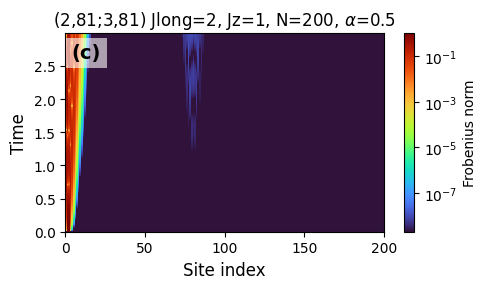

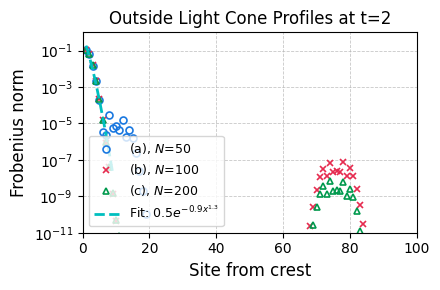

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = [50,100,200]
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 2

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
all_max = 0
for J in Jlong_values:
    data = load_mathematica_data(os.path.join(base_path, f"N{J}B0LFIMHeffb2lcalpha05farPlot.txt"))
    all_max = max(all_max, np.nanmax(data))

# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"N{J}B0LFIMHeffb2lcalpha05farPlot.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 3))
    im = plt.imshow(
    np.clip(raw_data, 1e-11, None),
    aspect="auto",
    origin="lower",
    cmap="turbo",
    norm=mcolors.LogNorm(vmin=2e-9, vmax=all_max),
    interpolation="nearest",   # 👈 No smoothing
    extent=[0, raw_data.shape[1], t_min, t_max],
    rasterized=True            # 👈 Forces raster pixels in SVG/PDF
    )

    # Determine subfigure label based on index
    label = {50: "(a)", 100: "(b)", 200: "(c)"}[J]

    # Add label in top-left corner of the plot
    plt.text(
        0.02, 0.95, label,
        transform=plt.gca().transAxes,
        fontsize=14, fontweight="bold",
        va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )


    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    plt.title(fr"(2,81;3,81) Jlong=2, Jz=1, N={J:.0f}, $\alpha$=0.5", fontsize=12)
    if J == 50:
        plt.title(fr"(2,14;3,14) Jlong=2, Jz=1, N={J:.0f}, $\alpha$=0.5", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_N{J}.svg", dpi=600)
    plt.show()

# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(4.5, 3))
# High-contrast RGB colors (normalized to [0,1])
colors = [
    (0.10, 0.47, 0.88),  # bright blue
    (0.90, 0.17, 0.31),  # red/pink
    (0.00, 0.60, 0.30)   # greenish teal
]


all_x_fit = []
all_y_fit = []

letters= ['(a)', '(b)', '(c)']
let=0
# Define marker styles (extend or reorder as needed)
markers = ["o", "x", "^", "D", "v", "<", ">", "P",  "*"]

for J, c, m in zip(Jlong_values, colors, markers):
    file_path = os.path.join(base_path, f"N{J}B0LFIMHeffb2lcalpha05farPlot.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 5:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect first few points for a single global fit
    n_fit = 9
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])

    plt.semilogy(
        sites, profile,
        marker=m,
        markerfacecolor='none',  # open marker
        markeredgecolor=c,
        markeredgewidth=1.2,
        markersize=5,
        linestyle="None",
        color=c,
        label=fr"{letters[let]}, $N$={J}"
    )

    let += 1

# -----------------------------
# Fit single model to combined early points
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Compute global fit curve
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)

# Add the single global fit to the same plot
plt.semilogy(x_dense, y_dense, "c--", linewidth=2,
             label=fr"Fit: ${A_fit:.1f}e^{{-{a_fit:.1f}x^{{{p_fit:.1f}}}}}$")

# Final formatting
plt.ylim(1e-11, 1)
plt.xlim(0, 100)
plt.xlabel("Site from crest", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
# --- Add gridlines ---
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(fontsize=9, loc="lower left")
plt.tight_layout()
plt.savefig("plt/Profiles_VaryN.svg", dpi=600)
plt.show()


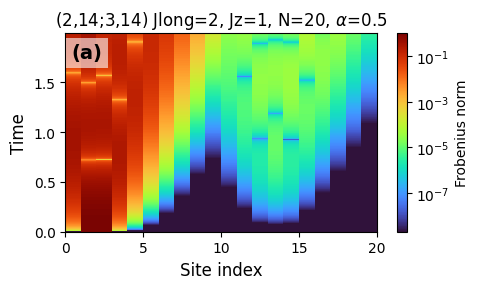

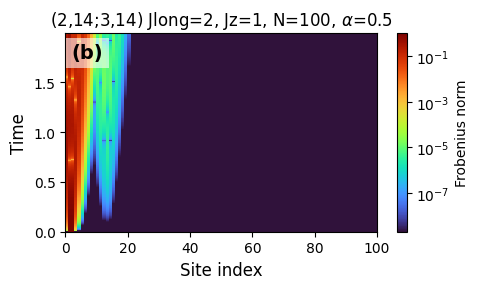

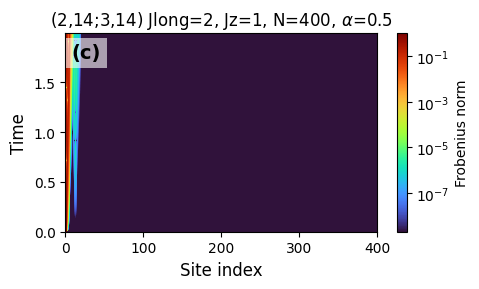

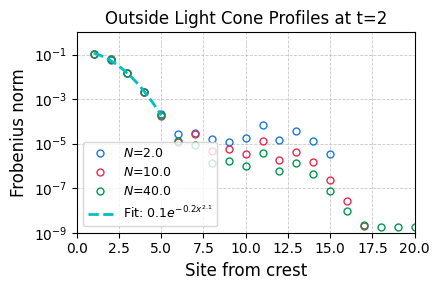

In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = np.array([20,100,400])
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 2

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
# all_max = 0
# for J in Jlong_values:
#     data = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{Jlong_values}.txt"))
#     all_max = max(all_max, np.nanmax(data))

# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 3))
    im = plt.imshow(
        np.clip(raw_data, 1e-11, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=2e-9, vmax=np.nanmax(raw_data)),
        interpolation="nearest",
        extent=[0, raw_data.shape[1], t_min, t_max],
        rasterized=True
    )

    label = {20: "(a)", 100: "(b)", 400: "(c)"}[J]

    plt.text(
        0.02, 0.95, label,
        transform=plt.gca().transAxes,
        fontsize=14, fontweight="bold",
        va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )

    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    plt.title(fr"(2,14;3,14) Jlong=2, Jz=1, N={J}, $\alpha$=0.5", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_N{J}.svg", dpi=600)
    plt.show()


# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(4.5, 3))
# High-contrast RGB colors (normalized to [0,1])
colors = [
    (0.10, 0.47, 0.88),  # bright blue
    (0.90, 0.17, 0.31),  # red/pink
    (0.00, 0.60, 0.30)   # greenish teal
]


all_x_fit = []
all_y_fit = []

letters= ['(a)', '(b)', '(c)']
let=0
for J, c in zip(Jlong_values, colors):
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 5:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect first few points for a single global fit
    n_fit =5
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])
    plt.semilogy(
    sites, profile, "o",
    markerfacecolor='none',     # open circles (no fill)
    markeredgecolor=c,          # colored edges
    markersize=5,
    label=fr"$N$={J/10:.1f}"
    )   
    let+=1

# -----------------------------
# Fit single model to combined early points
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Compute global fit curve
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)

# Add the single global fit to the same plot
plt.semilogy(x_dense, y_dense, "c--", linewidth=2,
             label=fr"Fit: ${A_fit:.1f}e^{{-{a_fit:.1f}x^{{{p_fit:.1f}}}}}$")

# Final formatting
plt.ylim(1e-9, 1)
plt.xlim(0, 20)
plt.xlabel("Site from crest", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
# --- Add gridlines ---
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(fontsize=9, loc="lower left")
plt.tight_layout()
plt.savefig("plt/Profiles_VaryN2.svg", dpi=600)
plt.show()


Fit slope = 0.475, intercept = -1.775


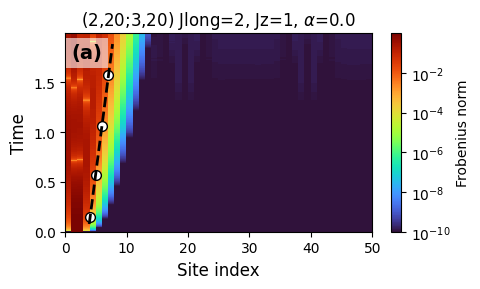

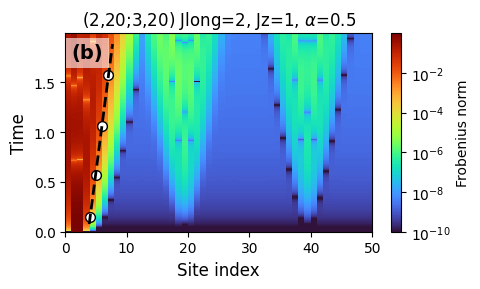

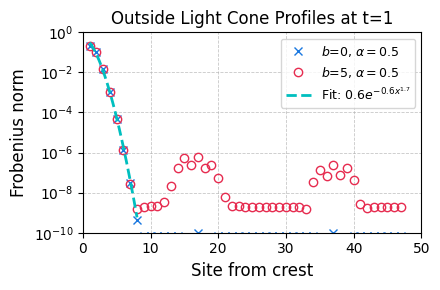

In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = np.array([0,5])
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 1

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
# all_max = 0
# for J in Jlong_values:
#     data = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{Jlong_values}.txt"))
#     all_max = max(all_max, np.nanmax(data))
arrivals = [
    (4, 0.15), (5, 0.57), (6, 1.06), (7, 1.57)
]
x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times
# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
# x_fit = np.linspace(x_points.min(), x_points.max(), 200)
x_fit = np.linspace(3.9, 7.7, 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")
# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2lcfarb3Varyalpha{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 3))
    im = plt.imshow(
        np.clip(raw_data, 1e-11, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-10, vmax=np.nanmax(raw_data)),
        interpolation="nearest",
        extent=[0, raw_data.shape[1], t_min, t_max],
        rasterized=True
    )
    # Overlay first arrival points
    plt.plot(x_points, y_points, 'wo', markersize=7,
            markeredgecolor="k", label="First arrivals")

    # Overlay best-fit line
    plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

    label = {0: "(a)", 5: "(b)", 4: "(c)"}[J]

    plt.text(
        0.02, 0.95, label,
        transform=plt.gca().transAxes,
        fontsize=14, fontweight="bold",
        va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )

    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    plt.xlim(0, 50)
    plt.title(fr"(2,20;3,20) Jlong=2, Jz=1, $\alpha$={J/10:.1f}", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_alpha{J}.svg", dpi=600)
    plt.show()


# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(4.5, 3))
# High-contrast RGB colors (normalized to [0,1])
colors = [
    (0.10, 0.47, 0.88),  # bright blue
    (0.90, 0.17, 0.31),  # red/pink
    (0.00, 0.60, 0.30)   # greenish teal
]


all_x_fit = []
all_y_fit = []

letters= ['(a)', '(b)', '(c)']
let=0
# for J, c in zip(Jlong_values, colors):
#     file_path = os.path.join(base_path, f"B0LFIMb2lcfara05Varyb{J}.txt")
#     raw_data = load_mathematica_data(file_path)
#     n_steps = raw_data.shape[0]
#     t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
#     profile = raw_data[t_index, 3:]
#     sites = np.arange(1, profile.size + 1)
#     mask = profile > 1e-14
#     sites, profile = sites[mask], profile[mask]

#     # Collect first few points for a single global fit
#     n_fit =8
#     all_x_fit.extend(sites[:n_fit])
#     all_y_fit.extend(profile[:n_fit])
#     plt.semilogy(
#     sites, profile, "o",
#     markerfacecolor='none',     # open circles (no fill)
#     markeredgecolor=c,          # colored edges
#     markersize=5,
#     label=fr"$b$={J:.0f}"
#     )   
#     let+=1

# Define distinct markers
markers = ["x", "o", "^"]   # first = cross, rest = circles

for (J, c, m) in zip(Jlong_values, colors, markers):
    file_path = os.path.join(base_path, f"B0LFIMb2lcfarb3Varyalpha{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 3:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect first few points for a single global fit
    n_fit = 8
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])
    if J == 4:
        label = r"$b=3, \alpha\to\infty$"
    else:
        label = fr"$b$={J:.0f}, $\alpha=0.5$"

    plt.semilogy(
        sites, profile, m,
        markerfacecolor='none',     # open symbols
        markeredgecolor=c,
        markersize=6,
        linewidth=1.2,
        label=label
    )


# -----------------------------
# Fit single model to combined early points
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Compute global fit curve
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)

# Add the single global fit to the same plot
plt.semilogy(x_dense, y_dense, "c--", linewidth=2,
             label=fr"Fit: ${A_fit:.1f}e^{{-{a_fit:.1f}x^{{{p_fit:.1f}}}}}$")

# Final formatting
plt.ylim(1e-10, 1)
plt.xlim(0, 50)
plt.xlabel("Site from crest", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
# --- Add gridlines ---
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(fontsize=9, loc="upper right")
plt.tight_layout()
plt.savefig("plt/Profiles_Varyalpha.svg", dpi=600)
plt.show()


Fit slope = 0.475, intercept = -1.775


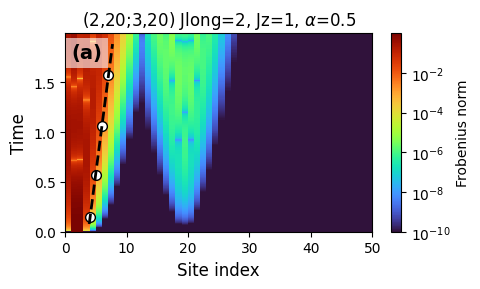

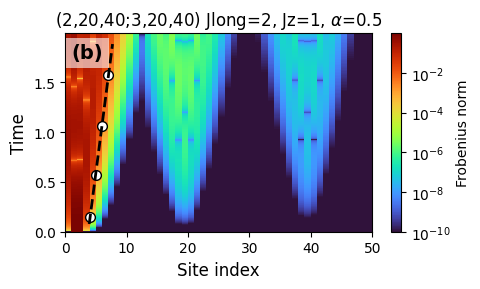

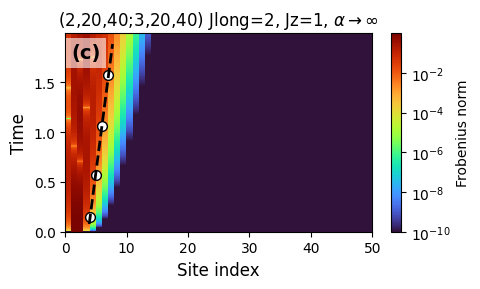

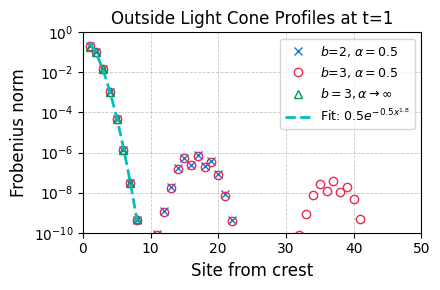

In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = np.array([2,3,4])
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 1

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
# all_max = 0
# for J in Jlong_values:
#     data = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{Jlong_values}.txt"))
#     all_max = max(all_max, np.nanmax(data))
arrivals = [
    (4, 0.15), (5, 0.57), (6, 1.06), (7, 1.57)
]
x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times
# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
# x_fit = np.linspace(x_points.min(), x_points.max(), 200)
x_fit = np.linspace(3.9, 7.7, 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")
# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05Varyb{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 3))
    im = plt.imshow(
        np.clip(raw_data, 1e-11, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-10, vmax=np.nanmax(raw_data)),
        interpolation="nearest",
        extent=[0, raw_data.shape[1], t_min, t_max],
        rasterized=True
    )
    # Overlay first arrival points
    plt.plot(x_points, y_points, 'wo', markersize=7,
            markeredgecolor="k", label="First arrivals")

    # Overlay best-fit line
    plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

    label = {2: "(a)", 3: "(b)", 4: "(c)"}[J]

    plt.text(
        0.02, 0.95, label,
        transform=plt.gca().transAxes,
        fontsize=14, fontweight="bold",
        va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )

    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    plt.xlim(0, 50)
    if J == 2:
        plt.title(fr"(2,20;3,20) Jlong=2, Jz=1, $\alpha$=0.5", fontsize=12)
    if J==3:
        plt.title(fr"(2,20,40;3,20,40) Jlong=2, Jz=1, $\alpha$=0.5", fontsize=12)
    if J==4:
        plt.title(fr"(2,20,40;3,20,40) Jlong=2, Jz=1, $\alpha\to\infty$", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_b{J}.svg", dpi=600)
    plt.show()


# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(4.5, 3))
# High-contrast RGB colors (normalized to [0,1])
colors = [
    (0.10, 0.47, 0.88),  # bright blue
    (0.90, 0.17, 0.31),  # red/pink
    (0.00, 0.60, 0.30)   # greenish teal
]


all_x_fit = []
all_y_fit = []

letters= ['(a)', '(b)', '(c)']
let=0
# for J, c in zip(Jlong_values, colors):
#     file_path = os.path.join(base_path, f"B0LFIMb2lcfara05Varyb{J}.txt")
#     raw_data = load_mathematica_data(file_path)
#     n_steps = raw_data.shape[0]
#     t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
#     profile = raw_data[t_index, 3:]
#     sites = np.arange(1, profile.size + 1)
#     mask = profile > 1e-14
#     sites, profile = sites[mask], profile[mask]

#     # Collect first few points for a single global fit
#     n_fit =8
#     all_x_fit.extend(sites[:n_fit])
#     all_y_fit.extend(profile[:n_fit])
#     plt.semilogy(
#     sites, profile, "o",
#     markerfacecolor='none',     # open circles (no fill)
#     markeredgecolor=c,          # colored edges
#     markersize=5,
#     label=fr"$b$={J:.0f}"
#     )   
#     let+=1

# Define distinct markers
markers = ["x", "o", "^"]   # first = cross, rest = circles

for (J, c, m) in zip(Jlong_values, colors, markers):
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05Varyb{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 3:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect first few points for a single global fit
    n_fit = 8
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])
    if J == 4:
        label = r"$b=3, \alpha\to\infty$"
    else:
        label = fr"$b$={J:.0f}, $\alpha=0.5$"

    plt.semilogy(
        sites, profile, m,
        markerfacecolor='none',     # open symbols
        markeredgecolor=c,
        markersize=6,
        linewidth=1.2,
        label=label
    )


# -----------------------------
# Fit single model to combined early points
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Compute global fit curve
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)

# Add the single global fit to the same plot
plt.semilogy(x_dense, y_dense, "c--", linewidth=2,
             label=fr"Fit: ${A_fit:.1f}e^{{-{a_fit:.1f}x^{{{p_fit:.1f}}}}}$")

# Final formatting
plt.ylim(1e-10, 1)
plt.xlim(0, 50)
plt.xlabel("Site from crest", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
# --- Add gridlines ---
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(fontsize=9, loc="upper right")
plt.tight_layout()
plt.savefig("plt/Profiles_Varyb.svg", dpi=600)
plt.show()


Fit slope = 0.475, intercept = -1.775


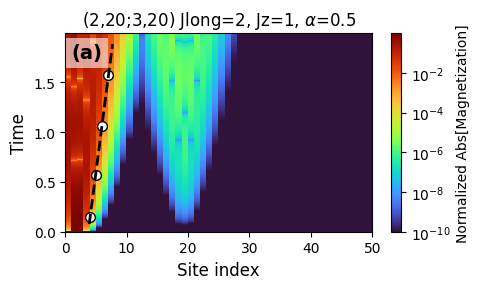

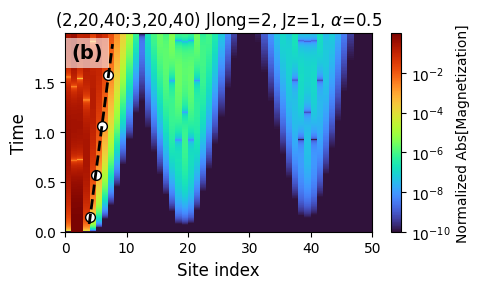

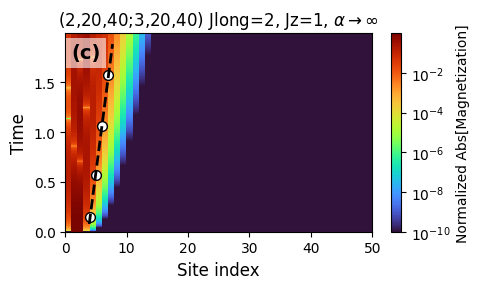

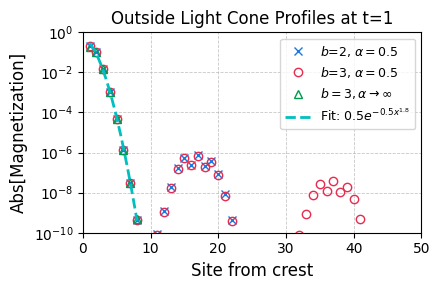

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = np.array([2,3,4])
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 1

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
# all_max = 0
# for J in Jlong_values:
#     data = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{Jlong_values}.txt"))
#     all_max = max(all_max, np.nanmax(data))
arrivals = [
    (4, 0.15), (5, 0.57), (6, 1.06), (7, 1.57)
]
x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times
# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
# x_fit = np.linspace(x_points.min(), x_points.max(), 200)
x_fit = np.linspace(3.9, 7.7, 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")
# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05VarybMag{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 3))
    im = plt.imshow(
        np.clip(raw_data, 1e-11, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-10, vmax=np.nanmax(raw_data)),
        interpolation="nearest",
        extent=[0, raw_data.shape[1], t_min, t_max],
        rasterized=True
    )
    # Overlay first arrival points
    plt.plot(x_points, y_points, 'wo', markersize=7,
            markeredgecolor="k", label="First arrivals")

    # Overlay best-fit line
    plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

    label = {2: "(a)", 3: "(b)", 4: "(c)"}[J]

    plt.text(
        0.02, 0.95, label,
        transform=plt.gca().transAxes,
        fontsize=14, fontweight="bold",
        va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )

    plt.colorbar(im, label="Normalized Abs[Magnetization]")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    plt.xlim(0, 50)
    if J == 2:
        plt.title(fr"(2,20;3,20) Jlong=2, Jz=1, $\alpha$=0.5", fontsize=12)
    if J==3:
        plt.title(fr"(2,20,40;3,20,40) Jlong=2, Jz=1, $\alpha$=0.5", fontsize=12)
    if J==4:
        plt.title(fr"(2,20,40;3,20,40) Jlong=2, Jz=1, $\alpha\to\infty$", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_bMag{J}.svg", dpi=600)
    plt.show()


# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(4.5, 3))
# High-contrast RGB colors (normalized to [0,1])
colors = [
    (0.10, 0.47, 0.88),  # bright blue
    (0.90, 0.17, 0.31),  # red/pink
    (0.00, 0.60, 0.30)   # greenish teal
]


all_x_fit = []
all_y_fit = []

letters= ['(a)', '(b)', '(c)']
let=0
# for J, c in zip(Jlong_values, colors):
#     file_path = os.path.join(base_path, f"B0LFIMb2lcfara05Varyb{J}.txt")
#     raw_data = load_mathematica_data(file_path)
#     n_steps = raw_data.shape[0]
#     t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
#     profile = raw_data[t_index, 3:]
#     sites = np.arange(1, profile.size + 1)
#     mask = profile > 1e-14
#     sites, profile = sites[mask], profile[mask]

#     # Collect first few points for a single global fit
#     n_fit =8
#     all_x_fit.extend(sites[:n_fit])
#     all_y_fit.extend(profile[:n_fit])
#     plt.semilogy(
#     sites, profile, "o",
#     markerfacecolor='none',     # open circles (no fill)
#     markeredgecolor=c,          # colored edges
#     markersize=5,
#     label=fr"$b$={J:.0f}"
#     )   
#     let+=1

# Define distinct markers
markers = ["x", "o", "^"]   # first = cross, rest = circles

for (J, c, m) in zip(Jlong_values, colors, markers):
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05VarybMag{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 3:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect first few points for a single global fit
    n_fit = 8
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])
    if J == 4:
        label = r"$b=3, \alpha\to\infty$"
    else:
        label = fr"$b$={J:.0f}, $\alpha=0.5$"

    plt.semilogy(
        sites, profile, m,
        markerfacecolor='none',     # open symbols
        markeredgecolor=c,
        markersize=6,
        linewidth=1.2,
        label=label
    )


# -----------------------------
# Fit single model to combined early points
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Compute global fit curve
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)

# Add the single global fit to the same plot
plt.semilogy(x_dense, y_dense, "c--", linewidth=2,
             label=fr"Fit: ${A_fit:.1f}e^{{-{a_fit:.1f}x^{{{p_fit:.1f}}}}}$")

# Final formatting
plt.ylim(1e-10, 1)
plt.xlim(0, 50)
plt.xlabel("Site from crest", fontsize=12)
plt.ylabel("Abs[Magnetization]", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
# --- Add gridlines ---
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(fontsize=9, loc="upper right")
plt.tight_layout()
plt.savefig("plt/Profiles_VarybMag.svg", dpi=600)
plt.show()


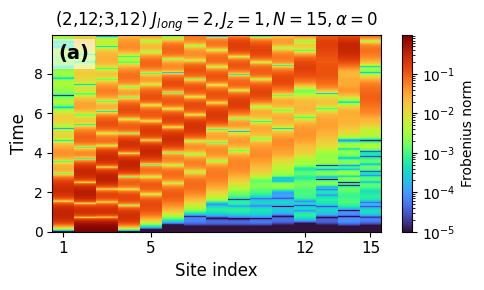

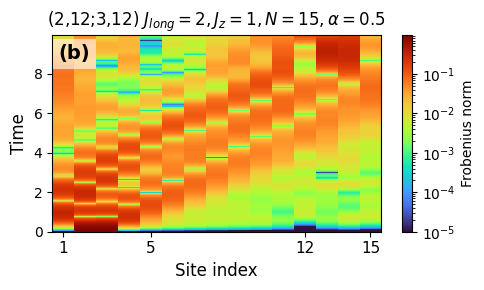

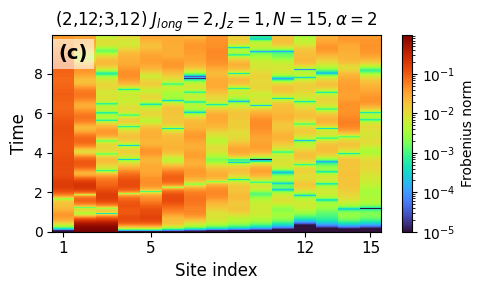

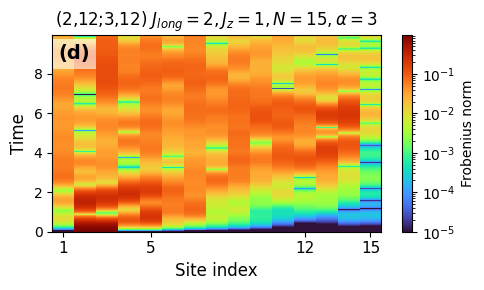

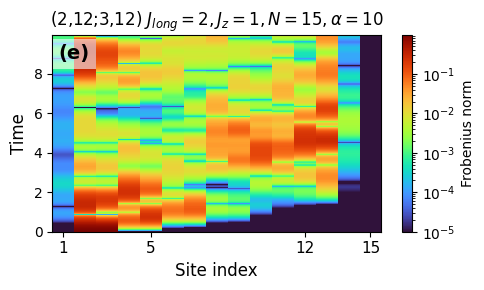

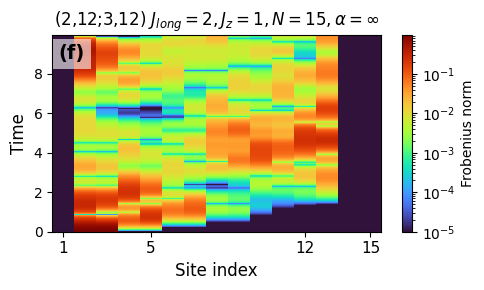

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

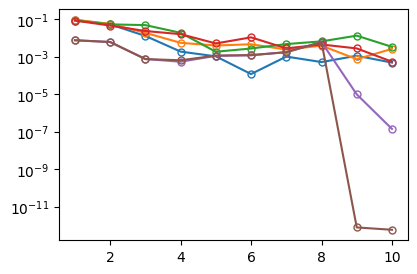

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = np.array([0, 5, 20, 30, 100, 1000 ])
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 2

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
# all_max = 0
# for J in Jlong_values:
#     data = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{Jlong_values}.txt"))
#     all_max = max(all_max, np.nanmax(data))

# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2Varya0{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 3))
    im = plt.imshow(
        np.clip(raw_data, 1e-12, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-5, vmax=np.nanmax(raw_data)),
        interpolation="nearest",
        extent=[0, raw_data.shape[1], t_min, t_max],
        rasterized=True
    )

    label = {0: "(a)", 5: "(b)", 20: "(c)",30: "(d)", 100: "(e)", 1000: "(f)"}[J]

    plt.text(
        0.02, 0.95, label,
        transform=plt.gca().transAxes,
        fontsize=14, fontweight="bold",
        va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )

    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    if J == 5:
        alpha_label = "0.5"
    elif J == 1000:
        alpha_label = r"\infty"
    else:
        alpha_label = f"{J/10:.0f}"

    plt.title(fr"(2,12;3,12) $J_{{long}}=2, J_z=1, N=15, \alpha={alpha_label}$", fontsize=12)



    # --- Custom X ticks (aligned to site centers) ---
    xticks = np.array([1, 5, 12, 15])   # or range(0, raw_data.shape[1], 5)
    plt.xticks(xticks - 0.5, [str(x) for x in xticks], fontsize=11)


    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_alpha{J}.svg", dpi=600)
    plt.show()


# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(4.5, 3))
# High-contrast RGB colors (normalized to [0,1])
colors = [
    (0.12, 0.47, 0.71),  # blue
    (1.00, 0.50, 0.05),  # orange
    (0.17, 0.63, 0.17),  # green
    (0.84, 0.15, 0.16),  # red
    (0.58, 0.40, 0.74),  # purple
    (0.55, 0.34, 0.29)   # brown
]


all_x_fit = []
all_y_fit = []

letters= ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
let=0
for J, c in zip(Jlong_values, colors):
    file_path = os.path.join(base_path, f"B0LFIMb2Varya0{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 5:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect first few points for a single global fit
    n_fit =5
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])
    plt.semilogy(
    sites, profile, "o-",
    markerfacecolor='none',     # open circles (no fill)
    markeredgecolor=c,          # colored edges
    markersize=5,
    label = (
            fr"$\alpha={J/10:.1f}$" if J == 5 
            else fr"$\alpha=\infty$" if J == 1000 
            else fr"$\alpha={J/10:.0f}$"
        )
    )   
    let+=1

# -----------------------------
# Fit single model to combined early points
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Compute global fit curve
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)

# Add the single global fit to the same plot
plt.semilogy(x_dense, y_dense, "c--", linewidth=2,
             label=fr"Fit: ${A_fit:.1f}e^{{-{a_fit:.1f}x^{{{p_fit:.1f}}}}}$")

# Final formatting
plt.ylim(1e-9, 1)
plt.xlim(0, 20)
plt.xlabel("Site from crest", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
# --- Add gridlines ---
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(fontsize=9, loc="lower left")
plt.tight_layout()
plt.savefig("plt/Profiles_Varyalpha2.svg", dpi=600)
plt.show()

# 



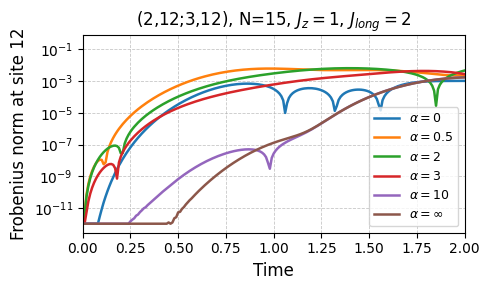

In [3]:
#-----------------------------
# Signal at site 14 vs time for different α
# -----------------------------
plt.figure(figsize=(5, 3))

# Distinct colors for each alpha
colors = [
    (0.12, 0.47, 0.71),  # blue
    (1.00, 0.50, 0.05),  # orange
    (0.17, 0.63, 0.17),  # green
    (0.84, 0.15, 0.16),  # red
    (0.58, 0.40, 0.74),  # purple
    (0.55, 0.34, 0.29)   # brown
]

site_index = 11   # <-- site of interest (1-based in your paper)
for J, c in zip(Jlong_values, colors):
    file_path = os.path.join(base_path, f"B0LFIMb2Varya0{J}.txt")
    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        continue

    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit

    # Adjust for 0-based indexing in Python
    if site_index >= raw_data.shape[1]:
        print(f"⚠️ Site {site_index} out of range for {file_path}")
        continue

    signal = raw_data[:, site_index]

    # Clip for log plotting
    signal = np.clip(signal, 1e-12, None)

    plt.semilogy(
        time_axis, signal,
        '-', color=c, linewidth=1.8,
        label = (
            fr"$\alpha={J/10:.1f}$" if J == 5 
            else fr"$\alpha=\infty$" if J == 1000 
            else fr"$\alpha={J/10:.0f}$"
        )

    )

# -----------------------------
# Final formatting
# -----------------------------
plt.xlim(0, 2.0)   # show only up to t = 2.0 units
plt.xlabel("Time", fontsize=12)
plt.ylabel("Frobenius norm at site 12", fontsize=12)
plt.title(r"(2,12;3,12), N=15, $J_z=1$, $J_{{long}}=2$", fontsize=12)
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(fontsize=9, loc="lower right")
plt.tight_layout()
plt.savefig("plt/Site14_VaryAlpha.svg", dpi=600)
plt.show()

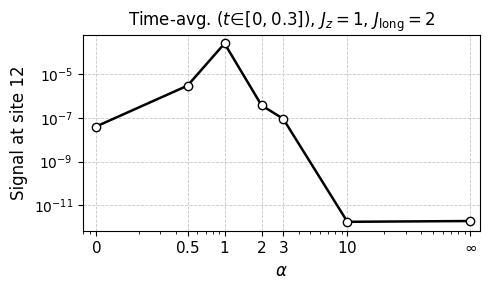

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os

# -----------------------------
# Time-averaged signal at site 12 vs α (for t in [0,0.5])
# -----------------------------
plt.figure(figsize=(5, 3))

site_index = 11   # 0-based index → site 12 in paper
t_min, t_max = 0.0, 0.3
time_averages = []
alphas = []
Jlong_values = np.array([5, 10, 20, 30, 100, 1000])  # skip 0 here (we'll handle separately)

# --- Compute α > 0 cases ---
for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2Varya0{J}.txt")
    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        continue

    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    mask = (time_axis >= t_min) & (time_axis <= t_max)
    if not np.any(mask):
        print(f"⚠️ No time points in range for {file_path}")
        continue

    signal = raw_data[mask, site_index]
    avg_value = np.mean(signal)
    time_averages.append(avg_value)
    alphas.append(J / 10)

alphas = np.array(alphas)
time_averages = np.array(time_averages)

# --- Add α = 0 case manually ---
J0 = 0
file_path = os.path.join(base_path, f"B0LFIMb2Varya0{J0}.txt")
if os.path.exists(file_path):
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    mask = (time_axis >= t_min) & (time_axis <= t_max)
    avg0 = np.mean(raw_data[mask, site_index])
    # Insert α = 0 point (plotted at small value 0.09)
    alphas = np.insert(alphas, 0, 0.09)
    time_averages = np.insert(time_averages, 0, avg0)

# --- Plot ---
plt.plot(
    alphas, time_averages,
    'o-', linewidth=1.8, markersize=6,
    color='k', markerfacecolor='white'
)

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.07, 120)

# --- Custom X ticks and labels ---
xticks = [0.09, 0.5, 1, 2, 3, 10, 100]
xlabels = [r"$0$", r"$0.5$", r"$1$", r"$2$", r"$3$", r"$10$", r"$\infty$"]
plt.xticks(xticks, xlabels, fontsize=11)

# --- Labels and styling ---
plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel(r"Signal at site 12", fontsize=12)
plt.title(r"Time-avg. $(t\!\in\![0,0.3])$, $J_z{=}1$, $J_{\mathrm{long}}{=}2$", fontsize=12)
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.savefig("plt/TimeAvg_vs_Alpha.svg", dpi=600)
plt.show()


In [21]:
time_averages

array([4.02727225e-08, 3.01633394e-06, 2.59789236e-04, 3.77934316e-07,
       9.12777227e-08, 1.71618208e-12, 1.86374214e-12])

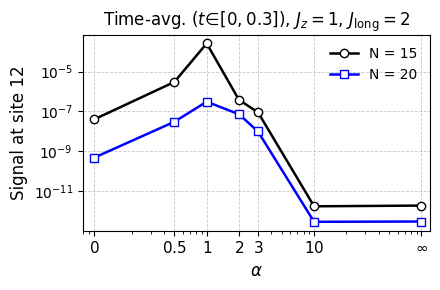

In [11]:
import numpy as np
import matplotlib.pyplot as plt

time_averages13 = np.array([4.02727225e-08, 3.01633394e-06, 2.59789236e-04, 3.77934316e-07,
       9.12777227e-08, 1.71618208e-12, 1.86374214e-12])
time_averages20 = np.array([4.79962050e-10, 3.01633394e-08, 3.07867219e-07, 7.20268948e-08, 9.87193259e-09,
       2.85609884e-13, 2.95196528e-13])

alphas = np.array([0.09, 0.5, 1, 2, 3, 10, 100])

plt.figure(figsize=(4.5, 3))

# --- Plot ---
plt.plot(
    alphas, time_averages13,
    'o-', linewidth=1.8, markersize=6,
    color='k', markerfacecolor='white',
    label='N = 15'
)
plt.plot(
    alphas, time_averages20,
    's-', linewidth=1.8, markersize=6,
    color='blue', markerfacecolor='white',
    label='N = 20'
)

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.07, 120)

# --- Custom X ticks and labels ---
xticks = [0.09, 0.5, 1, 2, 3, 10, 100]
xlabels = [r"$0$", r"$0.5$", r"$1$", r"$2$", r"$3$", r"$10$", r"$\infty$"]
plt.xticks(xticks, xlabels, fontsize=11)

# --- Labels and styling ---
plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel(r"Signal at site 12", fontsize=12)
plt.title(r"Time-avg. $(t\!\in\![0,0.3])$, $J_z{=}1$, $J_{\mathrm{long}}{=}2$", fontsize=12)
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(frameon=False, fontsize=10)
plt.tight_layout()
plt.savefig("plt/TimeAvg_vs_Alpha.svg", dpi=600)
plt.show()


In [ ]:
time_averagesN13

array([4.02727225e-08, 3.01633394e-06, 2.59789236e-04, 3.77934316e-07,
       9.12777227e-08, 1.71618208e-12, 1.86374214e-12])

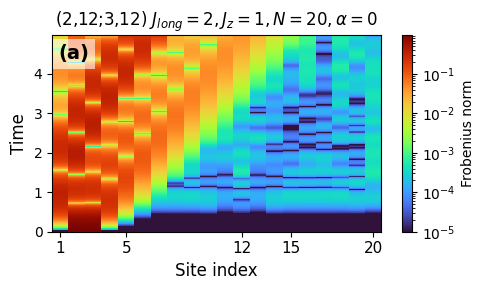

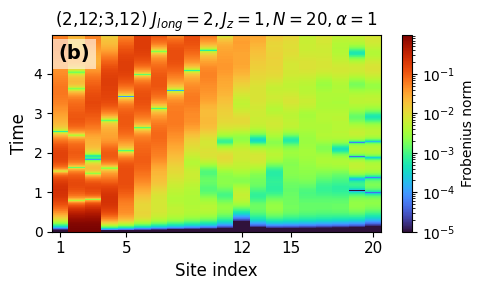

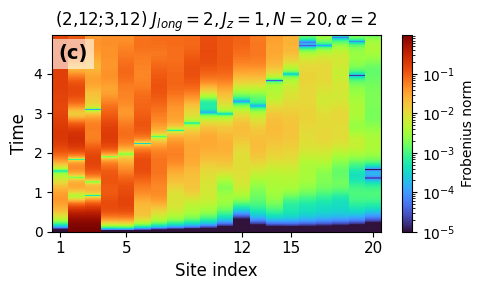

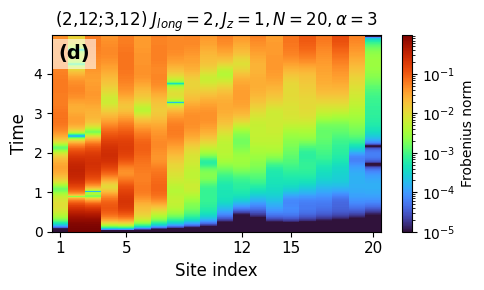

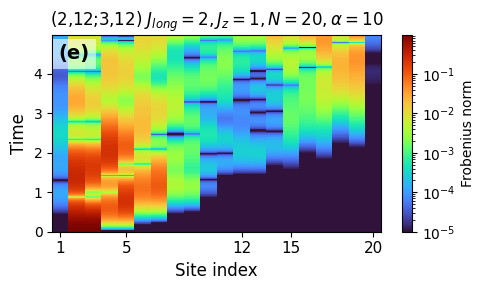

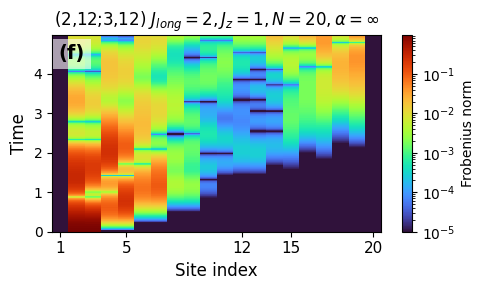

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

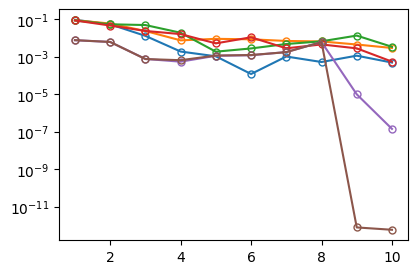

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = np.array([0, 10, 20, 30, 100, 1000 ])
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 2

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
# all_max = 0
# for J in Jlong_values:
#     data = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{Jlong_values}.txt"))
#     all_max = max(all_max, np.nanmax(data))

# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"N20B0LFIMb2Varya0{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 3))
    im = plt.imshow(
        np.clip(raw_data, 1e-12, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-5, vmax=np.nanmax(raw_data)),
        interpolation="nearest",
        extent=[0, raw_data.shape[1], t_min, t_max],
        rasterized=True
    )

    label = {0: "(a)", 10: "(b)", 20: "(c)",30: "(d)", 100: "(e)", 1000: "(f)"}[J]

    plt.text(
        0.02, 0.95, label,
        transform=plt.gca().transAxes,
        fontsize=14, fontweight="bold",
        va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )

    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    if J == 5:
        alpha_label = "0.5"
    elif J == 1000:
        alpha_label = r"\infty"
    else:
        alpha_label = f"{J/10:.0f}"

    plt.title(fr"(2,12;3,12) $J_{{long}}=2, J_z=1, N=20, \alpha={alpha_label}$", fontsize=12)



    # --- Custom X ticks (aligned to site centers) ---
    xticks = np.array([1, 5, 12, 15, 20])   # or range(0, raw_data.shape[1], 5)
    plt.xticks(xticks - 0.5, [str(x) for x in xticks], fontsize=11)


    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_N20alpha{J}.svg", dpi=600)
    plt.show()


# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(4.5, 3))
# High-contrast RGB colors (normalized to [0,1])
colors = [
    (0.12, 0.47, 0.71),  # blue
    (1.00, 0.50, 0.05),  # orange
    (0.17, 0.63, 0.17),  # green
    (0.84, 0.15, 0.16),  # red
    (0.58, 0.40, 0.74),  # purple
    (0.55, 0.34, 0.29)   # brown
]


all_x_fit = []
all_y_fit = []

letters= ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
let=0
for J, c in zip(Jlong_values, colors):
    file_path = os.path.join(base_path, f"B0LFIMb2Varya0{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 5:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect first few points for a single global fit
    n_fit =5
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])
    plt.semilogy(
    sites, profile, "o-",
    markerfacecolor='none',     # open circles (no fill)
    markeredgecolor=c,          # colored edges
    markersize=5,
    label = (
            fr"$\alpha={J/10:.1f}$" if J == 5 
            else fr"$\alpha=\infty$" if J == 1000 
            else fr"$\alpha={J/10:.0f}$"
        )
    )   
    let+=1

# -----------------------------
# Fit single model to combined early points
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Compute global fit curve
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)

# Add the single global fit to the same plot
plt.semilogy(x_dense, y_dense, "c--", linewidth=2,
             label=fr"Fit: ${A_fit:.1f}e^{{-{a_fit:.1f}x^{{{p_fit:.1f}}}}}$")

# Final formatting
plt.ylim(1e-9, 1)
plt.xlim(0, 20)
plt.xlabel("Site from crest", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
# --- Add gridlines ---
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(fontsize=9, loc="lower left")
plt.tight_layout()
plt.savefig("plt/Profiles_N20Varyalpha2.svg", dpi=600)
plt.show()

# 



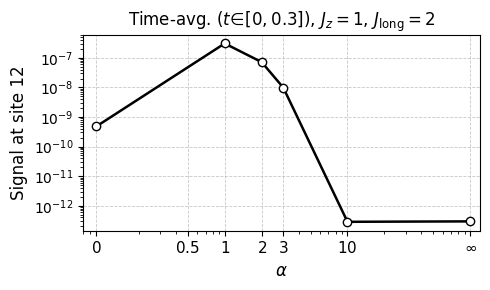

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os

# -----------------------------
# Time-averaged signal at site 12 vs α (for t in [0,0.5])
# -----------------------------
plt.figure(figsize=(5, 3))

site_index = 11   # 0-based index → site 12 in paper
t_min, t_max = 0.0, 0.2
time_averages = []
alphas = []
Jlong_values = np.array([10, 20, 30, 100, 1000])  # skip 0 here (we'll handle separately)

# --- Compute α > 0 cases ---
for J in Jlong_values:
    file_path = os.path.join(base_path, f"N20B0LFIMb2Varya0{J}.txt")
    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        continue

    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    mask = (time_axis >= t_min) & (time_axis <= t_max)
    if not np.any(mask):
        print(f"⚠️ No time points in range for {file_path}")
        continue

    signal = raw_data[mask, site_index]
    avg_value = np.mean(signal)
    time_averages.append(avg_value)
    alphas.append(J / 10)

alphas = np.array(alphas)
time_averages = np.array(time_averages)

# --- Add α = 0 case manually ---
J0 = 0
file_path = os.path.join(base_path, f"N20B0LFIMb2Varya0{J0}.txt")
if os.path.exists(file_path):
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    mask = (time_axis >= t_min) & (time_axis <= t_max)
    avg0 = np.mean(raw_data[mask, site_index])
    # Insert α = 0 point (plotted at small value 0.09)
    alphas = np.insert(alphas, 0, 0.09)
    time_averages = np.insert(time_averages, 0, avg0)

# --- Plot ---
plt.plot(
    alphas, time_averages,
    'o-', linewidth=1.8, markersize=6,
    color='k', markerfacecolor='white'
)

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.07, 120)

# --- Custom X ticks and labels ---
xticks = [0.09, 0.5, 1, 2, 3, 10, 100]
xlabels = [r"$0$", r"$0.5$", r"$1$", r"$2$", r"$3$", r"$10$", r"$\infty$"]
plt.xticks(xticks, xlabels, fontsize=11)

# --- Labels and styling ---
plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel(r"Signal at site 12", fontsize=12)
plt.title(r"Time-avg. $(t\!\in\![0,0.3])$, $J_z{=}1$, $J_{\mathrm{long}}{=}2$", fontsize=12)
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.savefig("plt/TimeAvg_vs_N20Alpha.svg", dpi=600)
plt.show()


In [24]:
time_averages

array([4.79962050e-10, 3.07867219e-07, 7.20268948e-08, 9.87193259e-09,
       2.85609884e-13, 2.95196528e-13])

In [2]:
!pip install brokenaxes

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\shrey\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


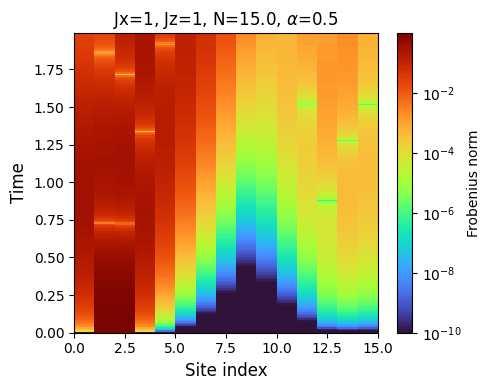

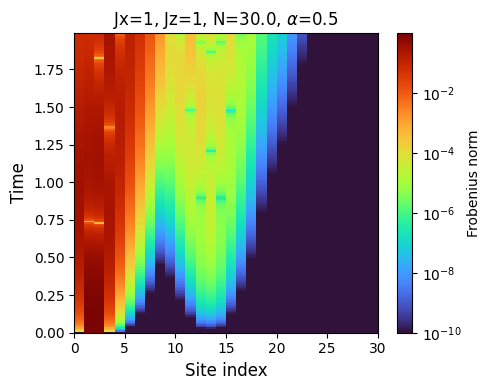

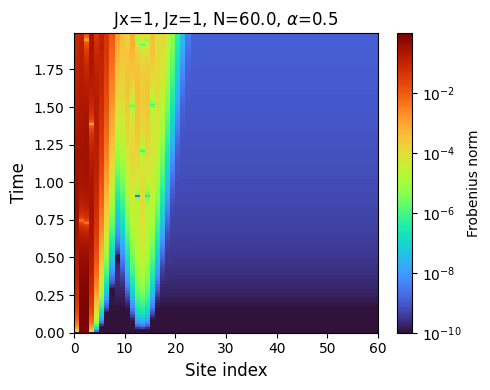

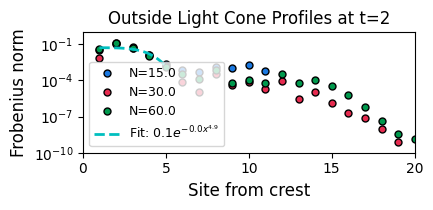

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = [15,30,60]
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 2

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
all_max = 0
for J in Jlong_values:
    data = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05Jx1VaryNWscaling{J}.txt"))
    all_max = max(all_max, np.nanmax(data))

# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05Jx1VaryNWscaling{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 4))
    im = plt.imshow(
    np.clip(raw_data, 1e-10, None),
    aspect="auto",
    origin="lower",
    cmap="turbo",
    norm=mcolors.LogNorm(vmin=1e-10, vmax=all_max),
    interpolation="nearest",   # 👈 No smoothing
    extent=[0, raw_data.shape[1], t_min, t_max],
    rasterized=True            # 👈 Forces raster pixels in SVG/PDF
    )

    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    plt.title(fr"Jx=1, Jz=1, N={J:.1f}, $\alpha$=0.5", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_N{J}.svg", dpi=600)
    plt.show()

# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(4.5, 2.2))
# High-contrast RGB colors (normalized to [0,1])
colors = [
    (0.10, 0.47, 0.88),  # bright blue
    (0.90, 0.17, 0.31),  # red/pink
    (0.00, 0.60, 0.30)   # greenish teal
]


all_x_fit = []
all_y_fit = []

for J, c in zip(Jlong_values, colors):
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05Jx1VaryNWscaling{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 4:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect first few points for a single global fit
    n_fit = 5
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])

    plt.semilogy(sites, profile, "o", color=c, markersize=5,
                 markeredgecolor="k", label=f"N={J:.1f}")

# -----------------------------
# Fit single model to combined early points
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Compute global fit curve
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)

# Add the single global fit to the same plot
plt.semilogy(x_dense, y_dense, "c--", linewidth=2,
             label=fr"Fit: ${A_fit:.1f}e^{{-{a_fit:.1f}x^{{{p_fit:.1f}}}}}$")

# Final formatting
plt.ylim(1e-10, 1)
plt.xlim(0, 20)
plt.xlabel("Site from crest", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
plt.legend(fontsize=9, loc="lower left")
plt.tight_layout()
# plt.savefig("plt/Profiles_VaryN.svg", dpi=600)
plt.show()


t = 0.10 → slope = -0.912
t = 0.50 → slope = -0.936
t = 2.00 → slope = -2.025


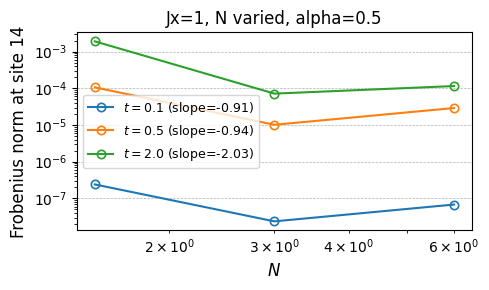

In [ ]:
# -----------------------------
# Plot: Site 14 value vs Jlong at fixed times (log-log)
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

Jlong_values = [15,30,60]
fixed_times = [0.1, 0.5, 2.0]
site_index = 13  # site 14 (0-based)
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(5, 3))

for t_fixed, c in zip(fixed_times, colors):
    values_at_t = []

    for J in Jlong_values:
        file_path = os.path.join(base_path, f"B0LFIMb2lcfara05Jx1VaryNWscaling{J}.txt")
        raw_data = load_mathematica_data(file_path)
        n_steps = raw_data.shape[0]
        time_axis = np.arange(n_steps) / steps_per_unit

        # Find the closest time index
        idx = np.argmin(np.abs(time_axis - t_fixed))
        val = raw_data[idx, site_index]
        values_at_t.append(val)
         # --- Log–log fit (y = A * N^slope) ---
        mask = (values_at_t > 0)
        slope, intercept = np.polyfit(np.log(Ns[mask]), np.log(values_at_t[mask]), 1)
        print(f"t = {t_fixed:>4.2f} → slope = {slope:.3f}")

        y_fit = np.exp(intercept) * Ns ** slope

        plt.loglog(Ns, values_at_t, "o-", color=c, markerfacecolor='none',
                markeredgewidth=1.2, label=fr"$t={t_fixed}$ (slope={slope:.2f})")
        plt.loglog(Ns, y_fit, "--", color=c, alpha=0.5)

    # Convert to arrays for fitting
    J_vals = np.array(Jlong_values) / 10.0
    y_vals = np.array(values_at_t)

    # Fit log(y) = m * log(J) + b  → slope = m
    mask = (y_vals > 1e-14)
    if np.sum(mask) >= 2:
        slope, intercept = np.polyfit(np.log(J_vals[mask]), np.log(y_vals[mask]), 1)
        print(f"t = {t_fixed:>4.2f} → slope = {slope:.3f}")
    else:
        slope = np.nan
        print(f"t = {t_fixed:>4.2f} → insufficient valid points")

    plt.loglog(
        J_vals, y_vals,
        "o-", color=c,
        markerfacecolor='none',
        markeredgewidth=1.2,
        label=fr"$t={t_fixed}$ (slope={slope:.2f})"
    )

plt.xlabel(r"$N$", fontsize=12)
plt.ylabel("Frobenius norm at site 14", fontsize=12)
plt.title("Jx=1, N varied, alpha=0.5", fontsize=12)
plt.legend(fontsize=9)
plt.grid(True, which="major", ls="--", lw=0.5)
plt.tight_layout()
# plt.savefig("plt/Site14_vs_Jlong_fixed_times.svg", dpi=600)
plt.show()


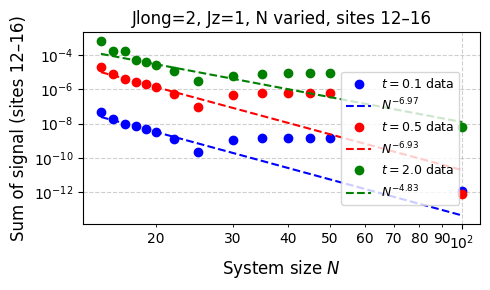

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter

# -----------------------------
# Helper: load Mathematica-style table
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            row = []
            for e in line.split(","):
                e = e.strip()
                if "+ 0." in e: e = e.split("+")[0].strip()
                if "*I" in e:   continue
                try:            row.append(float(e))
                except ValueError: pass
            if row: data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
N_values = np.array([15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50,100])
base_path = "src"
site_of_interest = 14
t_targets = [0.1, 0.5, 2.0]
tInterval = 0.01
steps_per_unit = 1 / tInterval

# -----------------------------
# Load data and extract signals
# -----------------------------
signals = {t: [] for t in t_targets}
for N in N_values:
    raw = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{N}.txt"))
    for t in t_targets:
        ti = min(int(t * steps_per_unit), raw.shape[0] - 1)
        # signals[t].append(raw[ti, site_of_interest])
        # Sum signal over sites 12–16 (inclusive)
        y_sum = np.mean(raw[ti, 12:17])
        signals[t].append(y_sum)

# -----------------------------
# Plot log–log
# -----------------------------
fig, ax = plt.subplots(figsize=(5, 3))
colors = ["blue", "red", "green"]

for t, c in zip(t_targets, colors):
    x = N_values
    y = np.array(signals[t])
    mask = (x > 0) & (y > 0)
    x, y = x[mask], y[mask]

    # Take only the first few points for fitting (e.g., first 4)
    n_fit_points = 5
    x_fit_subset = x[3:n_fit_points]
    y_fit_subset = y[3:n_fit_points]

    # Fit log(y) = log(A) - alpha * log(x)
    slope, intercept = np.polyfit(np.log(x_fit_subset), np.log(y_fit_subset), 1)
    alpha = -slope
    A = np.exp(intercept)

    # Generate smooth fit curve
    x_fit = np.geomspace(x.min(), x.max(), 200)
    y_fit = A * x_fit ** (-alpha)

    ax.loglog(x, y, "o", color=c, label=fr"$t={t}$ data")
    ax.loglog(x_fit, y_fit, "--", color=c, label=fr"$N^{{-{alpha:.2f}}}$")


# -----------------------------
# Format axes
# -----------------------------
ax.set_xlabel(r"System size $N$", fontsize=12)
ax.set_ylabel(r"Sum of signal (sites 12–16)", fontsize=12)
ax.set_title(r"Jlong=2, Jz=1, N varied, sites 12–16", fontsize=12)
ax.grid(True, which="major", linestyle="--", alpha=0.6)

# X axis: plain numbers (no scientific)
from matplotlib.ticker import FuncFormatter

# Your formatter (keeps integers or one decimal for small x)
import matplotlib.ticker as mticker
ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())


# Y axis: scientific notation
# ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# ax.yaxis.get_major_formatter().set_powerlimits((-2, 2))

ax.legend(fontsize=9)
plt.legend(fontsize=9,  loc=(0.65, 0.1))
fig.tight_layout()
# plt.savefig("plt/Signal_vs_N_loglog_simple.svg", dpi=600)
plt.show()


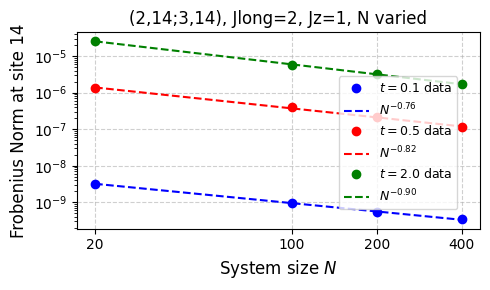

In [ ]:
sitesum100 = np.array([
    [0.1, 2.95795e-11], [0.2, 4.11164e-10], [0.3, 1.71338e-9],
    [0.4, 4.75062e-9], [0.5, 9.95777e-9], [0.6, 1.62452e-8],
    [0.7, 2.40116e-8], [0.8, 3.06272e-8], [0.9, 3.36132e-8],
    [1.0, 4.54229e-8], [1.1, 6.53094e-8], [1.2, 8.64266e-8],
    [1.3, 1.29877e-7], [1.4, 1.66198e-7], [1.5, 1.87698e-7],
    [1.6, 2.21240e-7], [1.7, 2.51343e-7], [1.8, 2.61102e-7],
    [1.9, 2.46807e-7], [2.0, 3.30038e-7], [2.1, 4.14858e-7],
    [2.2, 5.35527e-7], [2.3, 6.15428e-7], [2.4, 6.37870e-7],
    [2.5, 5.93794e-7], [2.6, 5.26324e-7], [2.7, 5.83286e-7],
    [2.8, 7.87361e-7], [2.9, 9.88648e-7], [3.0, 1.10528e-6]
])

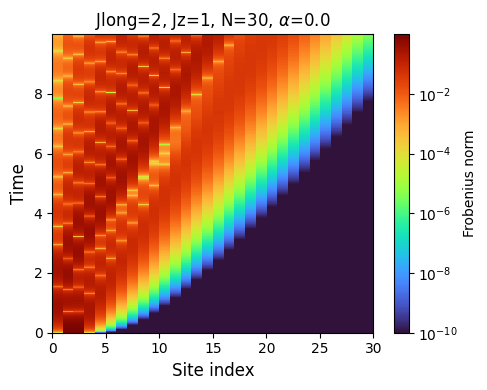

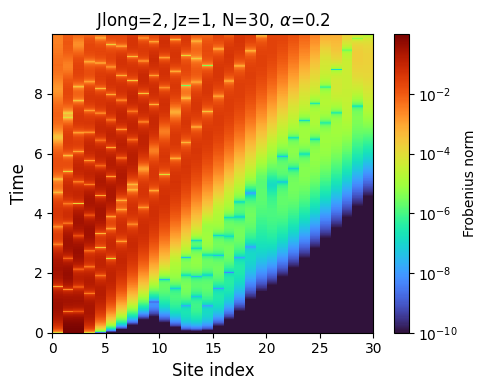

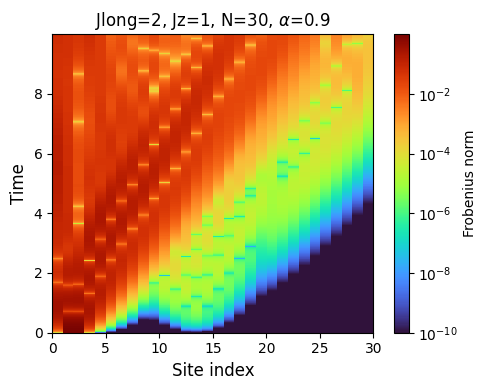

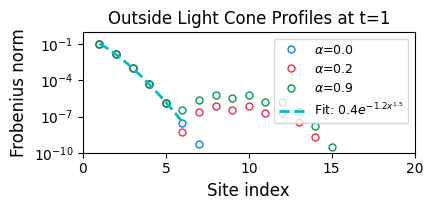

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = [0, 2, 9]
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 1

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
all_max = 0
for J in Jlong_values:
    data = load_mathematica_data(os.path.join(base_path, f"N30B0LFIMb2lcfarVaryalpha{J}.txt"))
    all_max = max(all_max, np.nanmax(data))

# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"N30B0LFIMb2lcfarVaryalpha{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 4))
    im = plt.imshow(
    np.clip(raw_data, 1e-10, None),
    aspect="auto",
    origin="lower",
    cmap="turbo",
    norm=mcolors.LogNorm(vmin=1e-10, vmax=all_max),
    interpolation="nearest",   # 👈 No smoothing
    extent=[0, raw_data.shape[1], t_min, t_max],
    rasterized=True            # 👈 Forces raster pixels in SVG/PDF
    )

    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    plt.title(fr"Jlong=2, Jz=1, N=30, $\alpha$={J/10:.1f}", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_N{J}.svg", dpi=600)
    plt.show()

# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(4.5, 2.2))
# High-contrast RGB colors (normalized to [0,1])
colors = [
    (0.10, 0.47, 0.88),  # bright blue
    (0.90, 0.17, 0.31),  # red/pink
    (0.00, 0.60, 0.30),  # teal-green
    (0.12, 0.45, 0.23)   # darker green
]


all_x_fit = []
all_y_fit = []

for J, c in zip(Jlong_values, colors):
    file_path = os.path.join(base_path, f"N30B0LFIMb2lcfarVaryalpha{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 4:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect first few points for a single global fit
    n_fit = 6
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])

    plt.semilogy(
    sites, profile, "o",
    markerfacecolor='none',     # open circles (no fill)
    markeredgecolor=c,          # colored edges
    markersize=5,
    label=fr"$\alpha$={J/10:.1f}"
    )   


# -----------------------------
# Fit single model to combined early points
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Compute global fit curve
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)

# Add the single global fit to the same plot
plt.semilogy(x_dense, y_dense, "c--", linewidth=2,
             label=fr"Fit: ${A_fit:.1f}e^{{-{a_fit:.1f}x^{{{p_fit:.1f}}}}}$")

# Final formatting
plt.ylim(1e-10, 1)
plt.xlim(0, 20)
plt.xlabel("Site index", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig("plt/Profiles_Varyalpha.svg", dpi=600)
plt.show()


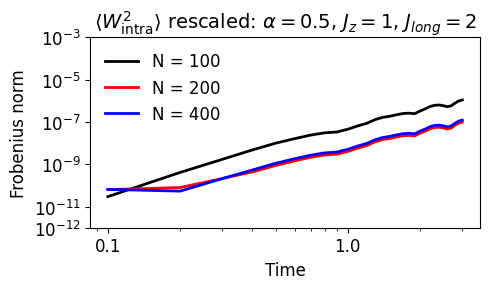

t = 0.10 → slope = 1.094
t = 0.50 → slope = -3.508
t = 2.00 → slope = -3.497


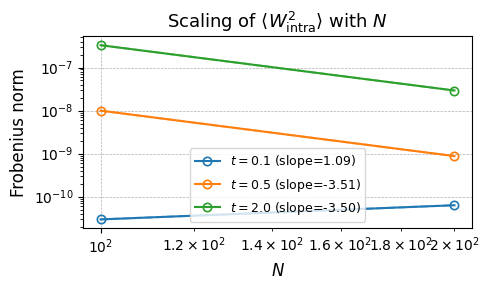

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Example: put your lists here (from Mathematica output)
sitesum100 = np.array([
    [0.1, 2.95795e-11], [0.2, 4.11164e-10], [0.3, 1.71338e-9],
    [0.4, 4.75062e-9], [0.5, 9.95777e-9], [0.6, 1.62452e-8],
    [0.7, 2.40116e-8], [0.8, 3.06272e-8], [0.9, 3.36132e-8],
    [1.0, 4.54229e-8], [1.1, 6.53094e-8], [1.2, 8.64266e-8],
    [1.3, 1.29877e-7], [1.4, 1.66198e-7], [1.5, 1.87698e-7],
    [1.6, 2.21240e-7], [1.7, 2.51343e-7], [1.8, 2.61102e-7],
    [1.9, 2.46807e-7], [2.0, 3.30038e-7], [2.1, 4.14858e-7],
    [2.2, 5.35527e-7], [2.3, 6.15428e-7], [2.4, 6.37870e-7],
    [2.5, 5.93794e-7], [2.6, 5.26324e-7], [2.7, 5.83286e-7],
    [2.8, 7.87361e-7], [2.9, 9.88648e-7], [3.0, 1.10528e-6]
])

sitesum200 = np.array([
    [0.1, 6.31498e-11], [0.2, 7.93421e-11], [0.3, 2.13737e-10],
    [0.4, 4.34403e-10], [0.5, 8.75189e-10], [0.6, 1.44740e-9],
    [0.7, 2.13933e-9], [0.8, 2.73084e-9], [0.9, 2.99738e-9],
    [1.0, 4.02700e-9], [1.1, 5.79881e-9], [1.2, 7.66038e-9],
    [1.3, 1.15110e-8], [1.4, 1.47227e-8], [1.5, 1.66077e-8],
    [1.6, 1.96149e-8], [1.7, 2.22808e-8], [1.8, 2.31438e-8],
    [1.9, 2.18970e-8], [2.0, 2.92229e-8], [2.1, 3.67442e-8],
    [2.2, 4.73733e-8], [2.3, 5.44056e-8], [2.4, 5.63562e-8],
    [2.5, 5.24498e-8], [2.6, 4.64868e-8], [2.7, 5.18199e-8],
    [2.8, 6.98086e-8], [2.9, 8.74469e-8], [3.0, 9.75777e-8]
])

sitesum400 = np.array([
    [0.1, 6.51926e-11], [0.2, 5.37986e-11], [0.3, 2.10346e-10],
    [0.4, 5.36232e-10], [0.5, 1.11159e-9], [0.6, 1.82618e-9],
    [0.7, 2.68316e-9], [0.8, 3.44915e-9], [0.9, 3.79734e-9],
    [1.0, 5.08680e-9], [1.1, 7.31319e-9], [1.2, 9.64373e-9],
    [1.3, 1.44840e-8], [1.4, 1.85285e-8], [1.5, 2.09310e-8],
    [1.6, 2.46757e-8], [1.7, 2.80252e-8], [1.8, 2.91146e-8],
    [1.9, 2.75248e-8], [2.0, 3.68117e-8], [2.1, 4.62894e-8],
    [2.2, 5.96937e-8], [2.3, 6.85384e-8], [2.4, 7.09884e-8],
    [2.5, 6.60122e-8], [2.6, 5.85044e-8], [2.7, 6.50064e-8],
    [2.8, 8.76549e-8], [2.9, 1.09862e-7], [3.0, 1.22571e-7]
])

# --- Rescale like in Mathematica ---
sitesum100Rescaled = np.column_stack([sitesum100[:,0], sitesum100[:,1]])
sitesum200Rescaled = np.column_stack([sitesum200[:,0], sitesum200[:,1]])
sitesum400Rescaled = np.column_stack([sitesum400[:,0], sitesum400[:,1]])


# --- Plot ---
plt.figure(figsize=(5,3))

plt.plot(sitesum100Rescaled[:,0], sitesum100Rescaled[:,1], 'k-', lw=2, label="N = 100")
plt.plot(sitesum200Rescaled[:,0], sitesum200Rescaled[:,1], 'r-', lw=2, label="N = 200")
plt.plot(sitesum400Rescaled[:,0], sitesum400Rescaled[:,1], 'b-', lw=2, label="N = 400")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Time", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(r"$\langle W_{\mathrm{intra}}^2 \rangle$ rescaled: $\alpha=0.5$, $J_z=1$, $J_{long}=2$",
          fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=12)  # tick label size
plt.legend(loc="upper left", frameon=False, fontsize=12)

# plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.ylim(1e-12, 1e-3)

# Fix log x-axis ticks to show raw numbers
ax = plt.gca()
ax.set_xscale("log")

# Major ticks at 0.1, 1, 10 ...
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=[1.0], numticks=20))
# Minor ticks for 2–9 between decades
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))

# Force raw number formatting instead of 10^n
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
# ax.xaxis.set_minor_formatter(ticker.NullFormatter())  # hide minor tick labels if too crowded

ax.set_yscale("log")

# Manually set ticks at alternate powers of 10
ax.set_yticks([1e-12,1e-11, 1e-9, 1e-7, 1e-5, 1e-3])

plt.tight_layout()

# === Save ===
# plt.savefig("plt/ScalingWithN_a05.svg", dpi=600, bbox_inches="tight")

plt.show()

datasets = {100: sitesum100, 200: sitesum200}#, 400: sitesum400}
times_to_check = [0.1, 0.5, 2.0]
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(5,3))

for t_fixed, c in zip(times_to_check, colors):
    values_at_t = []
    Ns = []

    for N, data in datasets.items():
        t = data[:, 0]
        y = data[:, 1]
        idx = np.argmin(np.abs(t - t_fixed))
        val = y[idx]
        values_at_t.append(val)
        Ns.append(N)

    Ns = np.array(Ns)
    values_at_t = np.array(values_at_t)

    # --- Log–log fit (y = A * N^slope) ---
    mask = (values_at_t > 0)
    slope, intercept = np.polyfit(np.log(Ns[mask]), np.log(values_at_t[mask]), 1)
    print(f"t = {t_fixed:>4.2f} → slope = {slope:.3f}")

    y_fit = np.exp(intercept) * Ns ** slope

    plt.loglog(Ns, values_at_t, "o-", color=c, markerfacecolor='none',
               markeredgewidth=1.2, label=fr"$t={t_fixed}$ (slope={slope:.2f})")
    plt.loglog(Ns, y_fit, "--", color=c, alpha=0.5)



plt.xlabel(r"$N$", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(r"Scaling of $\langle W_{\mathrm{intra}}^2 \rangle$ with $N$", fontsize=13)
plt.legend(fontsize=9)
plt.grid(True, which="major", ls="--", lw=0.5)
plt.tight_layout()
# plt.savefig("plt/Scaling_vs_N_fixed_t.svg", dpi=600)
plt.show()

